In [2263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import importlib
import clustering

importlib.reload(clustering);

In [2264]:
X, y = make_blobs(n_samples=200, n_features=2, centers=3, random_state=2021, cluster_std=2)

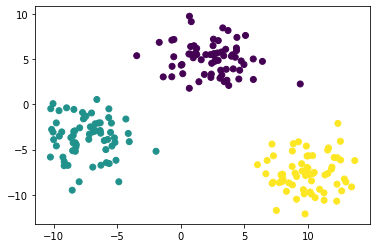

In [2265]:
plt.scatter(X[:, 0], X[:, 1], c=y)

**k_means**

In [2266]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=2021, stratify=y)

In [2267]:
k_means = clustering.KMeans()

In [2268]:
k_means.fit(X_train, 3, n_iters=10)

**Plot on actual data.**

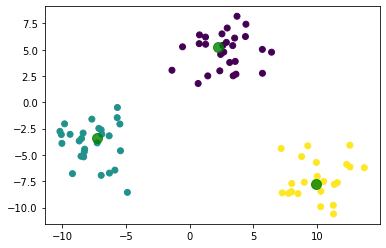

In [2269]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c="green", s=100, alpha=0.8)

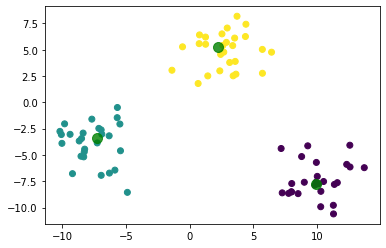

In [2270]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=k_means.predict(X_test))
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c="green", s=100, alpha=0.8)

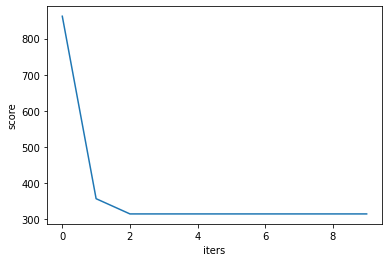

In [2271]:
plt.plot(k_means.scores)
plt.ylabel("score")
plt.xlabel("iters")
plt.show()

**k_means++**

In [2272]:
X, y = load_iris(return_X_y=True)

In [2273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=2021, stratify=y)

In [2274]:
k_means_pp = clustering.KMeansPlusPlus()
# k_means_pp._KMeansPlusPlus__init_alg(X, 3, clustering.DistMeasures.euclidean)
k_means_pp.fit(X_train, 3, n_iters=10)

Centroids in actual data points.

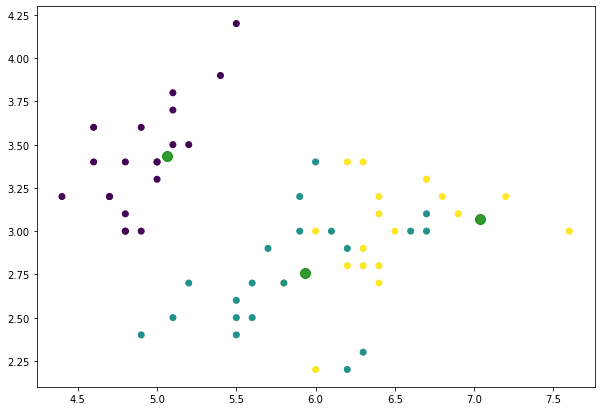

In [2275]:
plt.figure(figsize=(10, 7))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(k_means_pp.cluster_centers_[:, 0], k_means_pp.cluster_centers_[:, 1], c="green", s=100, alpha=0.8)

Centroids in predicted clusters.

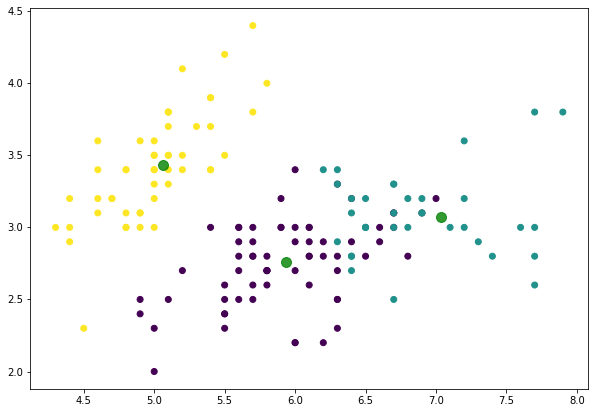

In [2276]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=k_means_pp.predict(X))
plt.scatter(k_means_pp.cluster_centers_[:, 0], k_means_pp.cluster_centers_[:, 1], c="green", s=100, alpha=0.8)

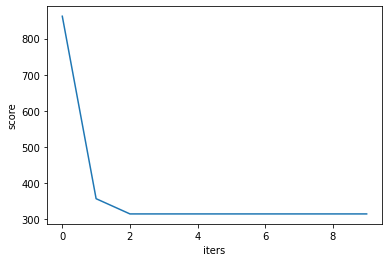

In [2277]:
plt.plot(k_means.scores)
plt.ylabel("score")
plt.xlabel("iters")
plt.show()

Although silhouette score was introduced in K-Medoid algorithm. Let's calculate the silhouette score for K-Means.

<img src="res/silhouette.png" width=500/>

Upsample data to get more beautiful plot.

In [2278]:
N = 2
up_sample_train = np.vstack(tuple(X_train + np.random.normal(0, 0.01, X_train.shape) for i in range(N)))
up_sample_test = np.vstack(tuple(X_test + np.random.normal(0, 0.01, X_test.shape) for i in range(N)))

In [2279]:
test_silhouette_score = clustering.silhouette(k_means_pp, up_sample_train, up_sample_test)    

In [2280]:
test_clusters = k_means_pp.predict(up_sample_test)

In [2281]:
# figure out the order to plot
label_orders = {}
for l in np.unique(test_clusters):
    inds = (test_clusters == l)
    label_orders[l] = test_silhouette_score[inds].mean()
    
label_orders = list(dict(sorted(label_orders.items(), key=lambda p : p[1])).keys())

Cluster 0 has mean silhouette score of 0.18212849926507058
Cluster 1 has mean silhouette score of 0.6879858380989622
Cluster 2 has mean silhouette score of 0.8076424231691253
Average silhouette width score is 0.517097475274895


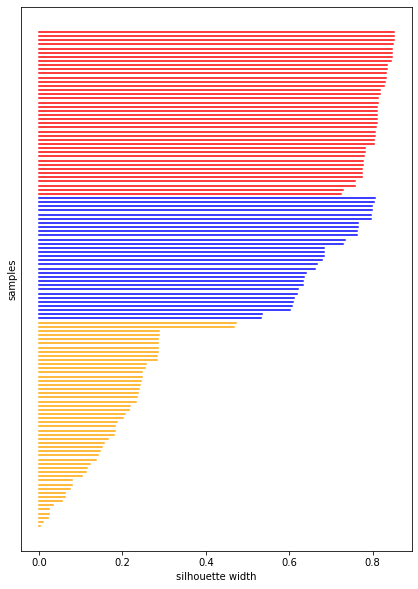

In [2282]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 10)

count = 0
for l, c in zip(label_orders, ["orange", "blue", "red"]):
    inds = (test_clusters == l)
    values = np.sort(test_silhouette_score[inds])
    print(f"Cluster {l} has mean silhouette score of {test_silhouette_score[inds].mean()}")
    for v, pos in zip(values, np.arange(count, len(values) + count, 1)):
        count += 1
        line = ax.plot([0, v], [pos, pos], color=c, label=f"Cluster {l}")
        
print(f"Average silhouette width score is {test_silhouette_score.mean()}")
        
plt.xlabel("silhouette width")
plt.ylabel("samples")
plt.xticks(np.linspace(0, 1, 6))
plt.yticks([])
plt.plot();

----------------------------------------------------------------------------------------------------

Suppose we did not know that iris had 3 different flower types("3 different cluster."), that is the very common.

Let's find out what optimal k value we would select with cross-validation.

In [2283]:
N_SPLITS = 5

folds = KFold(n_splits=N_SPLITS)
folds.shuffle = True

In [2284]:
rand_inds = np.random.permutation(len(X))
X = X[rand_inds]
y = y[rand_inds]

In [2285]:
# takes a while to run, since it goes up to 60 K.

k_means_scores_dict = {}
k_means_silhouette_scores = {}

for k in range(1, 60):
    
    k_means_train_scores = []
    k_means_test_scores = []
    silhouette_scores = []

    for inds1, inds2 in folds.split(X, y):
        X_train, y_train = X[inds1], y[inds1]
        X_test, y_test = X[inds2], y[inds2]

        k_means = clustering.KMeansPlusPlus()
        k_means.fit(X_train, k, n_iters=15)
        
        dists = k_means.predict_dists(X_train)
        k_means_train_scores.append(np.sum(dists.min(axis=0)))
        dists = k_means.predict_dists(X_test)
        k_means_test_scores.append(np.sum(dists.min(axis=0)))
        
        silhouette_scores.append(np.array(clustering.silhouette(k_means, X_train, X_test).mean()))
        
    k_means_scores_dict[k] = [k_means_train_scores, k_means_test_scores]
    k_means_silhouette_scores[k] = np.array(silhouette_scores).mean()

In [2286]:
for (k, v), s_v in zip(k_means_scores_dict.items(), k_means_silhouette_scores.values()):
    print(f"For k = {k}, the average loss is (test) {np.array(v[0]).mean()}, (train) {np.array(v[1]).mean()}, and silhouette score {s_v}")

For k = 1, the average loss is (test) 232.95011120615374, (train) 58.86379968900459, and silhouette score 0.0
For k = 2, the average loss is (test) 102.49041186977561, (train) 26.026744900528332, and silhouette score 0.5472260167225873
For k = 3, the average loss is (test) 81.82356350392482, (train) 20.81895578414899, and silhouette score 0.5134705314582251
For k = 4, the average loss is (test) 72.33335875392333, (train) 18.524043061237013, and silhouette score 0.4684625135511135
For k = 5, the average loss is (test) 67.94810573395569, (train) 18.49442847046033, and silhouette score 0.423153864167295
For k = 6, the average loss is (test) 67.23197302650549, (train) 17.683732726615176, and silhouette score 0.40855839193018595
For k = 7, the average loss is (test) 60.446391877180076, (train) 16.014127518728916, and silhouette score 0.3562348359290767
For k = 8, the average loss is (test) 59.835050354838685, (train) 17.170721664392108, and silhouette score 0.3632330016147464
For k = 9, the

*Here we can choose K using the elbow method.*

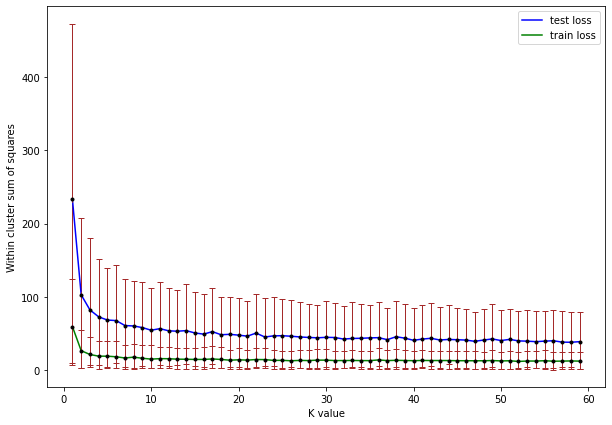

In [2287]:
plt.figure(figsize=(10, 7))

plt.plot(k_means_scores_dict.keys(), 
         np.array(list(k_means_scores_dict.values()))[:, 0].mean(axis=1), color="blue")

plt.plot(k_means_scores_dict.keys(), 
         np.array(list(k_means_scores_dict.values()))[:, 1].mean(axis=1), color="green")

plt.legend(["test loss", "train loss"])

plt.errorbar(k_means_scores_dict.keys(),
             np.array(list(k_means_scores_dict.values()))[:, 0].mean(axis=1),
             [np.array(list(k_means_scores_dict.values()))[:, 0].min(axis=1),
             np.array(list(k_means_scores_dict.values()))[:, 0].max(axis=1)],
             0, fmt='.k', ecolor='brown', lw=1, capsize=3)

plt.errorbar(k_means_scores_dict.keys(),
             np.array(list(k_means_scores_dict.values()))[:, 1].mean(axis=1),
             [np.array(list(k_means_scores_dict.values()))[:, 1].min(axis=1),
             np.array(list(k_means_scores_dict.values()))[:, 1].max(axis=1)],
             0, fmt='.k', ecolor='brown', lw=1, capsize=3)

plt.xlabel("K value")
plt.ylabel("Within cluster sum of squares")
plt.show()

Not sure why, but I get not descriptive plot from silhouette scores.

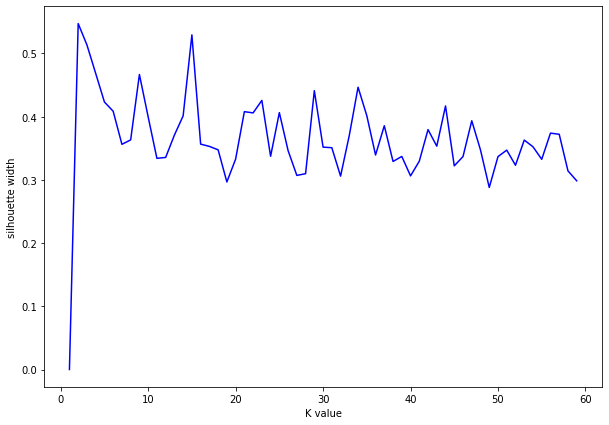

In [2288]:
plt.figure(figsize=(10, 7))

plt.plot(k_means_silhouette_scores.keys(), 
         np.array(list(k_means_silhouette_scores.values())), color="blue")

plt.xlabel("K value")
plt.ylabel("silhouette width")
plt.show()

Here we took K up to (|x|\*0.5) - 1. We can see train and test losses continue to decrease, no matter how much we increase K. This behaviour is unlike other algorithms we discussed, where with growing model complexity we would overfit at some point.

**GMM**

Main formulas.

<img src="res/gmm1.png" width=500 />
<img src="res/gmm2.png" width=500 />

Additional sources:

https://www.ics.uci.edu/~smyth/courses/cs274/notes/EMnotes.pdf

https://towardsdatascience.com/understanding-the-covariance-matrix-92076554ea44

In [2289]:
X, y = make_blobs(n_samples=200, n_features=2, centers=3, random_state=2021, cluster_std=2)

In [2290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021, stratify=y, shuffle=True)

In [2291]:
gmm = clustering.GuassianMixturesModel()
# gmm._GuassianMixturesModel__init_alg(X, 3, 15, clustering.DistMeasures.euclidean)

In [2292]:
gmm.fit(X, 3, 30)
gmm.predict_prob(X_train)[:10]

array([[0.55980603, 0.22009699, 0.22009699],
       [0.27145488, 0.27145488, 0.45709025],
       [0.33171522, 0.33171522, 0.33656955],
       [0.28562421, 0.42875157, 0.28562421],
       [0.38935204, 0.30532398, 0.30532398],
       [0.30291269, 0.30291269, 0.39417462],
       [0.32870001, 0.34259998, 0.32870001],
       [0.33333011, 0.33333011, 0.33333978],
       [0.24100103, 0.24100103, 0.51799794],
       [0.33320724, 0.33358552, 0.33320724]])

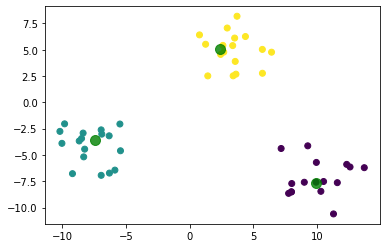

In [2293]:
# plt.figure(figsize=(10, 7))
plt.scatter(X_test[:, 0], X_test[:, 1], c=gmm.predict(X_test))
plt.scatter(gmm.cluster_centers_[:, 0], gmm.cluster_centers_[:, 1], c="green", s=100, alpha=0.8)

The guassian dists that GMM learned.

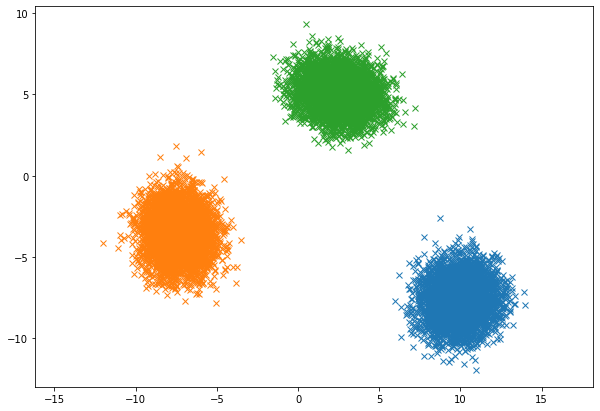

In [2294]:
plt.figure(figsize=(10, 7))
for j in range(3):
#     print(gmm.cov_matrices[j])
    x, y = np.random.default_rng().multivariate_normal(gmm.cluster_centers_[j], gmm.cov_matrices[j], 5000).T
    plt.plot(x, y, "x")
    plt.axis("equal")

Test on iris.

In [2295]:
X_iris, y_iris = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.25, random_state=2021, stratify=y_iris, shuffle=True)

In [2298]:
gmm = clustering.GuassianMixturesModel()
gmm.fit(X_iris, 3, 30)

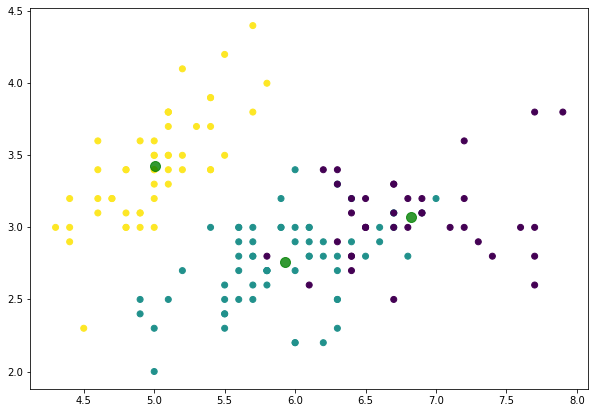

In [2299]:
plt.figure(figsize=(10, 7))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=gmm.predict(X_iris))
plt.scatter(gmm.cluster_centers_[:, 0], gmm.cluster_centers_[:, 1], c="green", s=100, alpha=0.8)

Below we can see how the guassians tried to "hug" the datapoints using their flexibilities (stretching), in 3 features of iris.

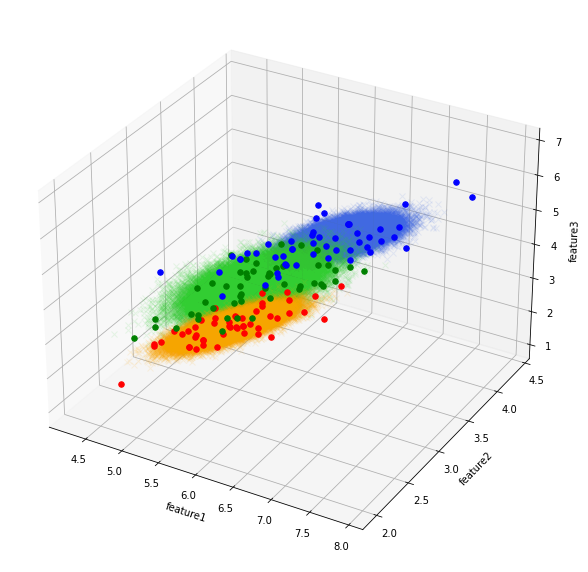

In [2300]:
fig = plt.figure()
fig.set_size_inches(10, 14)
ax = fig.add_subplot(projection='3d')
    
c_dict1 = {0 : "red", 1 : "green", 2 : "blue"}
c_dict2 = {0 : "orange", 1 : "limegreen", 2 : "royalblue"}

for l in np.unique(y_iris):
    inds = (y_iris == l)
    for sample in X_iris[inds]:
        
        x, y, z, _ = np.random.default_rng().multivariate_normal(gmm.cluster_centers_[l], gmm.cov_matrices[l], 1000).T
        c = [clustering.DistMeasures.euclidean(gmm.cluster_centers_[l], X_iris[inds])
             for l in range(3)]
        c = c_dict2[np.argmin(c)]
        ax.plot(x, y, z, "x", alpha=0.1, color=c)
        
        c = c_dict1[l]
        x, y, z, _  = sample
        ax.scatter(x, y, z, s=30, color=c)
        
ax.set_xlabel("feature1")
ax.set_ylabel("feature2")
ax.set_zlabel("feature3")
plt.show();